Extracting the sentiment versus estimated gender of participants on the mailing list. 

Disclaimer: BigBang uses a library that guesses the gender of a person based on their first name and census records. We understand that this method is prone to error. Only names with very high correlation with a particular gender are so identified. Because of these and other errors, we consider gender in statistical aggregates only. Please do not take these results as attributing gender to any particular individual on the mailing list.

In [1]:
%matplotlib inline

Import the BigBang modules as needed. These should be in your Python environment if you've installed BigBang correctly.

For sentiment analysis, we are using a pretrained python library, TextBlob, which we have tested is relatively fast.

In [2]:
import bigbang.ingress.mailman as mailman
import bigbang.analysis.graph as graph
import bigbang.analysis.process as process
from bigbang.parse import get_date
from bigbang.archive import Archive
from bigbang.archive import load as load_archive
import bigbang.analysis.utils as analysis_utils

import imp
imp.reload(process)

import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import math
import pytz
import pickle
import os

from bigbang import parse
from gender_detector import gender_detector as gd

from textblob import TextBlob

/tmp/ipykernel_5637/1012371525.py:9: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


Now let's load the data for analysis.

In [3]:
stem = False


import os 
cwd = os.getcwd()    

archives_names = ["httpbisa"]


archive_paths = list()
for archive_name in archives_names:
    archive_paths.append('../archives/'+archive_name+'.csv')
    

archives_list = [load_archive(arch_path).data for arch_path in archive_paths]
    
archives = Archive(pd.concat(archives_list))
archives_data = archives.data


For each of our lists, we'll clean up the names, find the first name if there is one, and guess its gender. Pandas groups the data together for comparison. We keep count of the names we find that are ambiguous, for the next step.

In [4]:
detector = gd.GenderDetector('us')


def guess_gender(name):
    if not name:
        return 'name unknown'
    try:
        if detector.guess(name) == 'unknown':
            return 'gender unknown'
        
        return detector.guess(name)
    except:
        return 'error'

Instead of estimating the gender again for recipients, we lookup in the senders list itself whose gender estimates have been populated

In [5]:
def lookup_index(df, mdf, val, field = 'From Gender'):
    vidx = df[df.index == val]
    if vidx.empty :
        return None
    else :
        #print(vidx.index.values[0])
        midx = mdf[mdf.index == vidx.index.values[0]]
        #print(midx.head())
        #print(midx.index)
        if midx.empty :
            return None
        else :
            return midx[field].values[0]

To process the data, we firstly drop rows that have missing information. Then we calculate the sentiment polarity of each email body, which signifies the sentiment posed by the sender, i.e., From, to the recipient, i.e., the In-Reply-To. Thereafter, the first name of the sender is guessed which is used to guess their gender and thereafter, the gender of the recipients. Finally, we drop rows that we were not able to process.

In [6]:
mod_data = archives_data.dropna()
mod_data = mod_data[mod_data['In-Reply-To'] != 'None']
#mod_data = mod_data.head(30)
mod_data['Sentiment'] = mod_data['Body'].map(lambda x: TextBlob(x).sentiment.polarity)
mod_data['From Name'] = mod_data['From'].map(lambda x: parse.clean_from(x))
mod_data['From First Name'] = mod_data['From Name'].map(lambda x: parse.guess_first_name(x))
mod_data['From Gender'] = mod_data['From First Name'].map(guess_gender)
mod_data['InReplyTo Gender'] = mod_data['In-Reply-To'].map(lambda x: lookup_index(archives_data, mod_data,x))
mod_data = mod_data.dropna()

The number of emails that were present in the mailing list archive is usually larger than the number of emails we could process primarily due to the limitations in coverage of guessing gender from first names. We shall attempt to improve this coverage using psycholinguistic tools forthwith.

In [7]:
mod_data['From'].size

25796

In [8]:
archives_data['From'].size

40147

Relevant statistics need to be printed to understand the participation of men and women in the mailing list. We sum up the number of emails from a particular sender, to remove duplicates. Thereafter, we print and plot the number of total emails and unique men, women senders, recipients as well as communication across and within genders.

#### The number of people of each gender sent and received emails to people of each gender

/tmp/ipykernel_5637/2884405722.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tempdata = mod_data.groupby(['From Gender','InReplyTo Gender','From'], as_index=False)['From','Subject'].count()


<Axes: xlabel='InReplyTo Gender', ylabel='From Gender'>

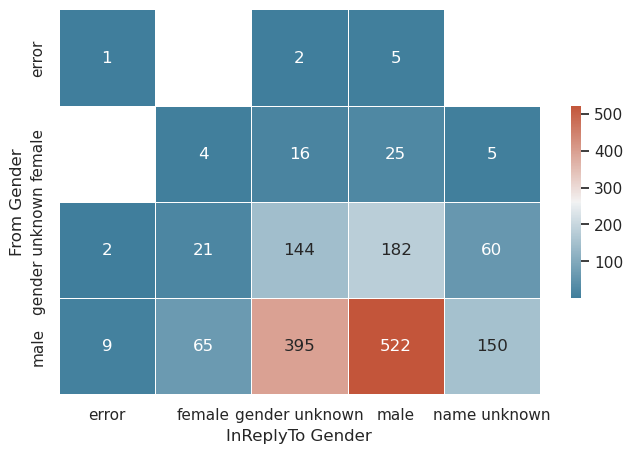

In [24]:
tempdata = mod_data.groupby(['From Gender','InReplyTo Gender','From'], as_index=False)['From','Subject'].count()

tempdata = pd.DataFrame(tempdata)

unique_interaction = pd.DataFrame(tempdata.groupby(['From Gender', 'InReplyTo Gender'],
                                                   as_index=False)['From'].count()).rename(columns={'From':'Count'})

#print(unique_interaction)

sb.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Compute the correlation matrix
ui_corr = unique_interaction.pivot(index='From Gender',columns='InReplyTo Gender', values='Count')

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the correct aspect ratio
sb.heatmap(ui_corr,cmap=cmap,annot=True,fmt=".0f",
           square=True, linewidths=.5, cbar_kws={"shrink": .5})



#### The number of people of each gender who sent or received emails in total  

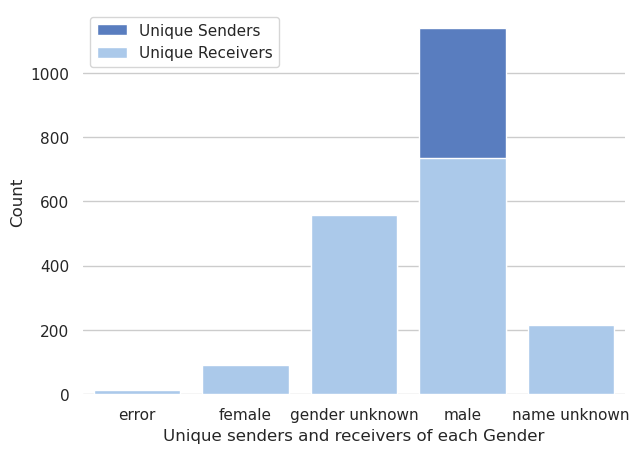

In [28]:
unique_senders = pd.DataFrame(tempdata.groupby(['From Gender'],
                                               as_index=False)['From'].count()).rename(columns={'From':'Count'})

#print(unique_senders)


unique_receivers = pd.DataFrame(tempdata.groupby(['InReplyTo Gender'],
                                                 as_index=False)['From'].count()).rename(columns={'From':'Count'})

#print(unique_receivers)


sb.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Plot the unique senders
sb.set_color_codes("muted")
sb.barplot(x="From Gender", y="Count", data=unique_senders,
            label="Unique Senders", color="b")

# Plot the unique receivers
sb.set_color_codes("pastel")
sb.barplot(x="InReplyTo Gender", y="Count", data=unique_receivers,
            label="Unique Receivers", color="b")


# Add a legend and informative axis label
ax.legend(ncol=1, loc="upper left", frameon=True)
ax.set(ylabel="Count",
       xlabel="Unique senders and receivers of each Gender")
sb.despine(left=True, bottom=True)



#### Response or interaction ratio of people of each gender towards each gender

<Axes: xlabel='InReplyTo Gender', ylabel='From Gender'>

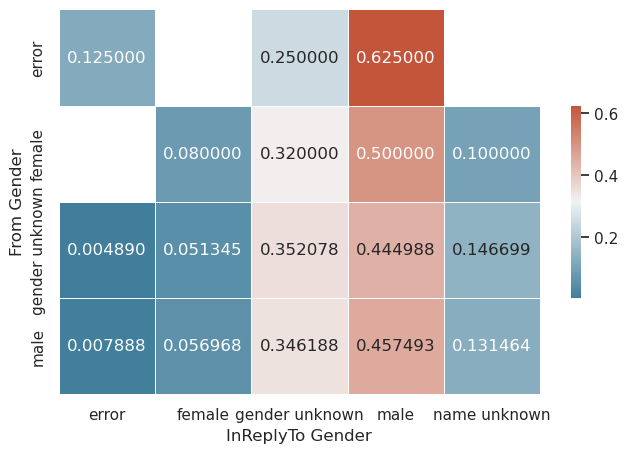

In [25]:
unique_replies_by_gender = tempdata.groupby('From Gender').count()['Subject']

unique_replied_by_gender = tempdata.groupby(['From Gender', 'InReplyTo Gender']).count()['Subject']


unique_interaction_ratio= (unique_replied_by_gender/unique_replies_by_gender).unstack()
#print(unique_interaction_ratio)

sb.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the correct aspect ratio
sb.heatmap(unique_interaction_ratio,cmap=cmap,annot=True,fmt=".6f",
           square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Number of emails in total sent or received by each gender to each gender

<Axes: xlabel='InReplyTo Gender', ylabel='From Gender'>

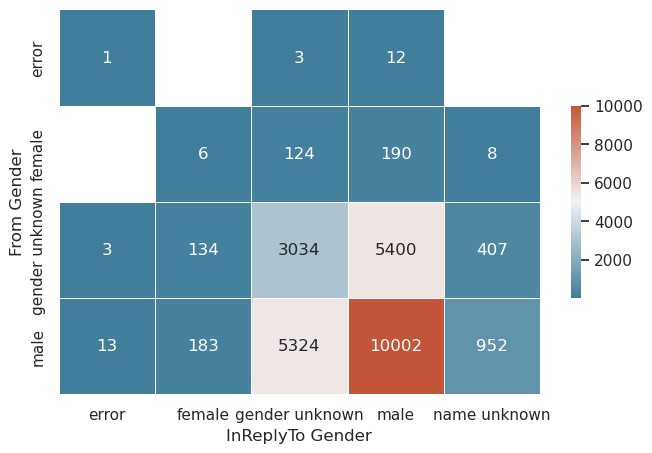

In [26]:
nonunique_interaction = pd.DataFrame(mod_data.groupby(['From Gender', 'InReplyTo Gender'],
                                                      as_index=False)['From'].count()).rename(columns={'From':'Count'})

#print(nonunique_interaction)

sb.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8, 5))

# Compute the correlation matrix
nui_corr = nonunique_interaction.pivot(index='From Gender',columns='InReplyTo Gender', values='Count')

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the correct aspect ratio
sb.heatmap(nui_corr,cmap=cmap,annot=True,fmt=".0f",
           square=True, linewidths=.5, cbar_kws={"shrink": .5})

#### Total emails sent or received by each gender

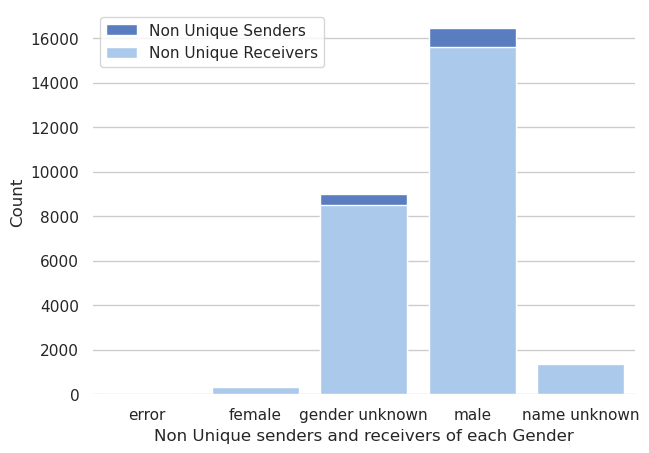

In [27]:
nonunique_senders = pd.DataFrame(mod_data.groupby(['From Gender'],
                                                  as_index=False)['From'].count()).rename(columns={'From':'Count'})

#print(nonunique_senders)

nonunique_receivers = pd.DataFrame(mod_data.groupby(['InReplyTo Gender'],
                                                    as_index=False)['From'].count()).rename(columns={'From':'Count'})

#print(nonunique_receivers)


sb.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(7, 5))

# Plot the non unique senders
sb.set_color_codes("muted")
sb.barplot(x="From Gender", y="Count", data=nonunique_senders,
            label="Non Unique Senders", color="b")

# Plot the non unique receivers
sb.set_color_codes("pastel")
sb.barplot(x="InReplyTo Gender", y="Count", data=nonunique_receivers,
            label="Non Unique Receivers", color="b")


# Add a legend and informative axis label
ax.legend(ncol=1, loc="upper left", frameon=True)
ax.set(ylabel="Count",
       xlabel="Non Unique senders and receivers of each Gender")
sb.despine(left=True, bottom=True)


#### Response or interaction ratio of total emails sent or received by each gender

<Axes: xlabel='InReplyTo Gender', ylabel='From Gender'>

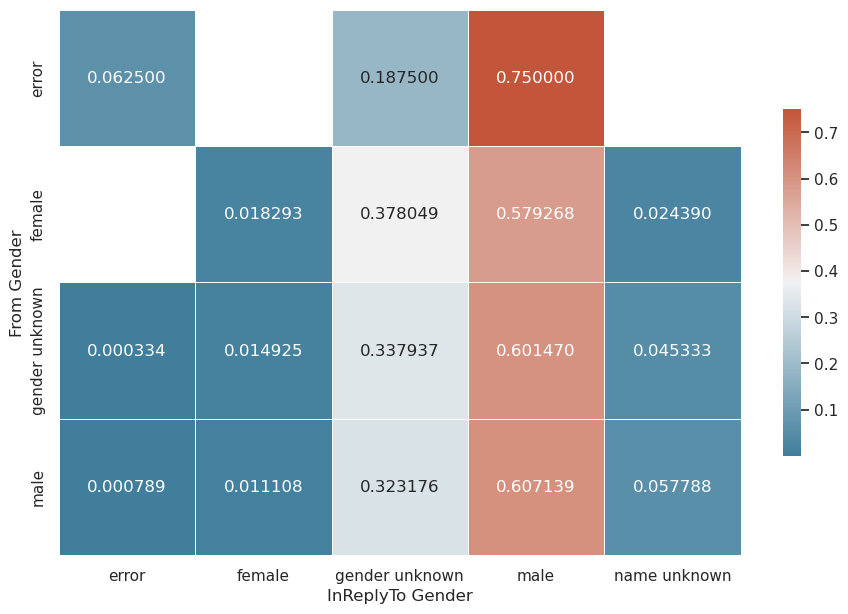

In [22]:
nonunique_replies_by_gender = mod_data.groupby('From Gender').count()['Subject']
nonunique_replied_by_gender = mod_data.groupby(['From Gender', 'InReplyTo Gender']).count()['Subject']

nonunique_interaction_ratio = (nonunique_replied_by_gender/nonunique_replies_by_gender).unstack()

#print(nonunique_interaction_ratio)

sb.set_theme(style="white")

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the correct aspect ratio
sb.heatmap(nonunique_interaction_ratio,cmap=cmap,annot=True,fmt=".6f",
           square=True, linewidths=.5, cbar_kws={"shrink": .5})


Finally we also identify the sentiment polarity statistics such as minimum, maximum, average, total, variance and standard deviation across and within genders in the mailing list. This gives us an overview of the tone of communication vis a vis gender in the mailing list. 

In [14]:
mod_data.groupby(['From Gender', 'InReplyTo Gender'])['Sentiment'].agg(['mean','var','max','min','std'])

mean       var       max       min
From Gender    InReplyTo Gender                                        
error          error             0.154949       NaN  0.154949  0.154949
               gender unknown    0.094383  0.004753  0.173148  0.045000
               male              0.159225  0.002018  0.229605  0.065530
female         female            0.051878  0.009553  0.156558 -0.114744
               gender unknown    0.143108  0.010901  0.500000 -0.087662
               male              0.142918  0.013134  0.533333 -0.121667
               name unknown      0.065812  0.008360  0.204762 -0.090000
gender unknown error             0.129721  0.003000  0.186667  0.077412
               female            0.173423  0.013227  0.557143 -0.050000
               gender unknown    0.150130  0.016335  0.750000 -0.750000
               male              0.156782  0.016787  1.000000 -1.000000
               name unknown      0.150990  0.013478  0.766667 -0.205556
male           error             0.143523  0.005628  0.340179  0.047436
               female            0.126170  0.019288  0.750000 -0.462500
               gender unknown    0.126698  0.014096  1.000000 -0.700000
               male              0.123760  0.010905  0.800000 -0.750000
               name unknown      0.125471  0.011108  1.000000 -0.175000

#### Distribution of Sentiment from men and women in the mailing list towards men and women

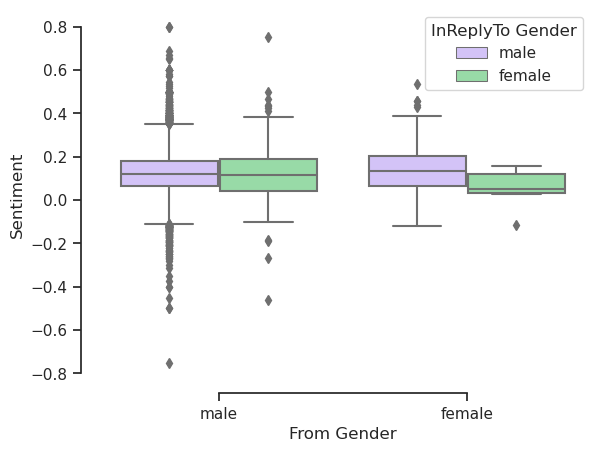

In [29]:
sentiment_across_genders = mod_data[((mod_data['From Gender']=='male') 
                                     | (mod_data['From Gender']=='female'))
                                    & ((mod_data['InReplyTo Gender']=='male') 
                                     | (mod_data['InReplyTo Gender']=='female'))]

sb.set_theme(style="ticks", palette="pastel")

# Draw a nested boxplot to show sentiment by each gender towards each gender
sb.boxplot(x="From Gender", y="Sentiment",
            hue="InReplyTo Gender", palette=["m", "g"],
            data=sentiment_across_genders)
sb.despine(offset=10, trim=True)